<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>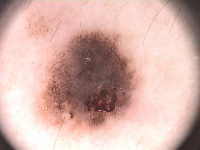</td><td>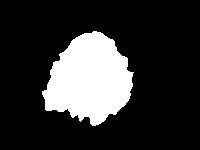</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
pip install googledrivedownloader

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]


In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

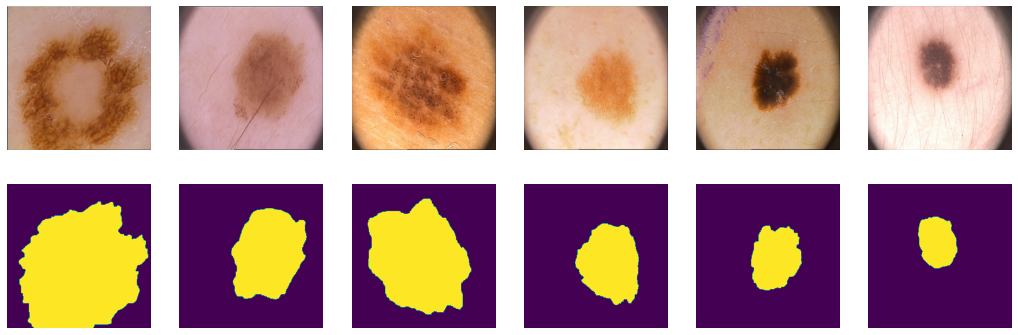

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch

In [13]:
#pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [14]:
#import torch_xla
#import torch_xla.core.xla_model as xm
#device = xm.xla_device(n=2, devkind='TPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

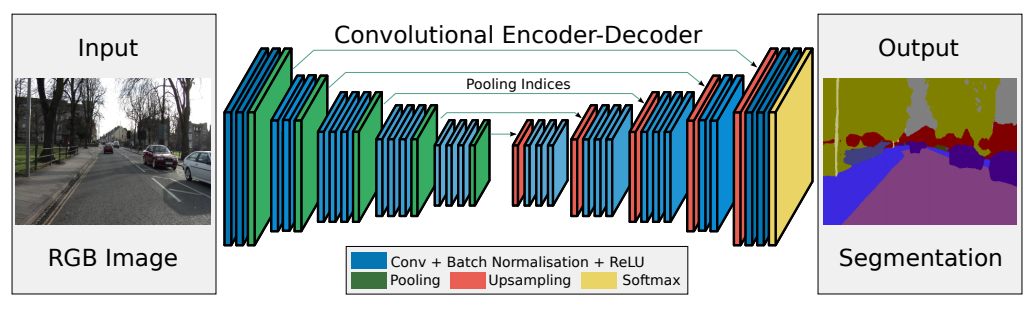

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

import plotly.express as pe

import plotly.graph_objects as go

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import pandas as pd

In [16]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, padding=1, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, padding=1, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
       
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, padding=1, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2 , stride=2)

        self.bottleneck_dec_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2 , stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, padding=1, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2 , stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, padding=1, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, padding=1, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, padding=1, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2 , stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2 , stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=1, kernel_size=3),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b0 = self.bottleneck_conv(e3)
        b1, indb1 = self.bottleneck_pool(b0)
        b2 = self.bottleneck_upsample(b1, indb1)
        b3 = self.bottleneck_dec_conv(b2)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b3, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_pred, y_real):
    assert y_pred.shape[0] == y_real.shape[0], "predict & target batch size don't match"
    dim0 = y_pred.shape[0]
    output = y_pred.float().contiguous().view(dim0, -1)
    target = y_real.float().contiguous().view(dim0, -1)
    bce = output - target*output + torch.log(1 + torch.exp(-output))

    return torch.mean(bce)

    # TODO 
    # please don't use nn.BCELoss. write it from scratch

In [19]:
y_1 = torch.randn((3, 4))
y_2 = torch.randn((3, 4))

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
loss_bcewithlogits = nn.BCEWithLogitsLoss()
loss_bcewithlogits(y_1, y_2) == bce_loss(y_1, y_2)

tensor(True)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    history_train_loss = []
    history_val_loss = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero 
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) #считаем лосс
            loss.backward()
            opt.step()

            X_batch = X_batch.cpu()
            Y_batch = Y_batch.cpu()
            Y_pred = Y_pred.cpu()

            # calculate loss to show the user
            avg_loss += loss.detach().cpu().numpy() / len(data_tr)

        history_train_loss.append(avg_loss)
        toc = time()
        print('loss_train: %f' % avg_loss)
        

        # show intermediate results
        model.eval()  # testing mode
        X_val = X_val.to(device)
        with torch.no_grad():
            Y_hat_probs = model(X_val).detach().cpu()
            loss_val = loss_fn(Y_hat_probs, Y_val)
            Y_hat = (torch.sigmoid(Y_hat_probs) >= 0.5).float()
        
        X_val = X_val.cpu()
        
        avg_loss_val += loss_val.numpy() 
        history_val_loss.append(avg_loss_val) 

        toc = time()
        print('loss_val: %f' % avg_loss_val)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(15, 10))
        for k in range(5):

            plt.subplot(4, 5, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 5, k+6)
            plt.imshow(Y_hat_probs[k, 0], cmap='gray')
            plt.title('Probs')
            plt.axis('off')

            plt.subplot(4, 5, k+11)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(4, 5, k+16)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('GroundTruth')
            plt.axis('off')


        #plt.suptitle('%d / %d - train_loss: %f' % (epoch+1, epochs, avg_loss))
        plt.suptitle('%d / %d - val_loss: %f - train_loss: %f' % (epoch+1, epochs, avg_loss_val, avg_loss))

        plt.show()

    return history_train_loss, history_val_loss

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred =[model(X_batch) for X_batch, _ in data]
    #Y_pred = model([X_batch for X_batch, _ in data])
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        #X_batch, Y_label = X_batch.to(device), Y_label
        Y_pred = (torch.sigmoid(model(X_batch)) >= 0.5) #.cpu()) #<TODO>
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
model = SegNet().to(device)

In [ ]:
segnet_total_params = sum(p.numel() for p in model.parameters())
segnet_total_params

24980929

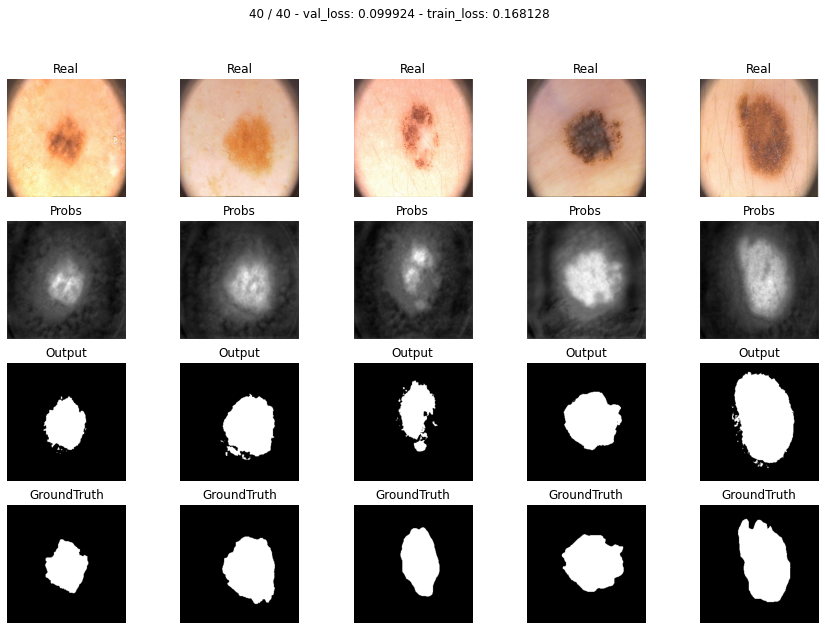

In [ ]:
max_epochs = 40
optimizer = optim.Adam(model.parameters())
loss_tr_segnet, loss_val_segnet = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_segnet_csv = pd.DataFrame(columns=['train', 'val'])
loss_segnet_csv['train'] = loss_tr_segnet
loss_segnet_csv['val'] = loss_val_segnet
loss_segnet_csv.to_csv('./gdrive/MyDrive/loss_segnet_csv.csv', index=False)

In [ ]:
loss_segnet_csv = pd.read_csv('./gdrive/MyDrive/loss_segnet_csv.csv')
loss_tr_segnet = loss_segnet_csv['train']
loss_val_segnet = loss_segnet_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_segnet,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Segnet, BCE Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
torch.save(model.state_dict(), 'SegNet.pth')
model.load_state_dict(torch.load('SegNet.pth'))

<All keys matched successfully>

In [ ]:
score_model(model.cpu(), iou_pytorch, data_val)

0.678000020980835

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real, smooth=.01):
    assert y_pred.shape[0] == y_real.shape[0], "predict & target batch size don't match"
    dim0 = y_pred.shape[0]
    output = torch.sigmoid(y_pred).float().contiguous().view(dim0, -1)
    target = y_real.float().contiguous().view(dim0, -1)

    num = 2 * torch.sum(torch.mul(output, target), dim=1) + smooth
    den = torch.sum(output + target, dim=1) + smooth #.pow(2) .abs()

    res = 1 - (num / den).sum() / 256 / 256
    return res 

Проводим тестирование:

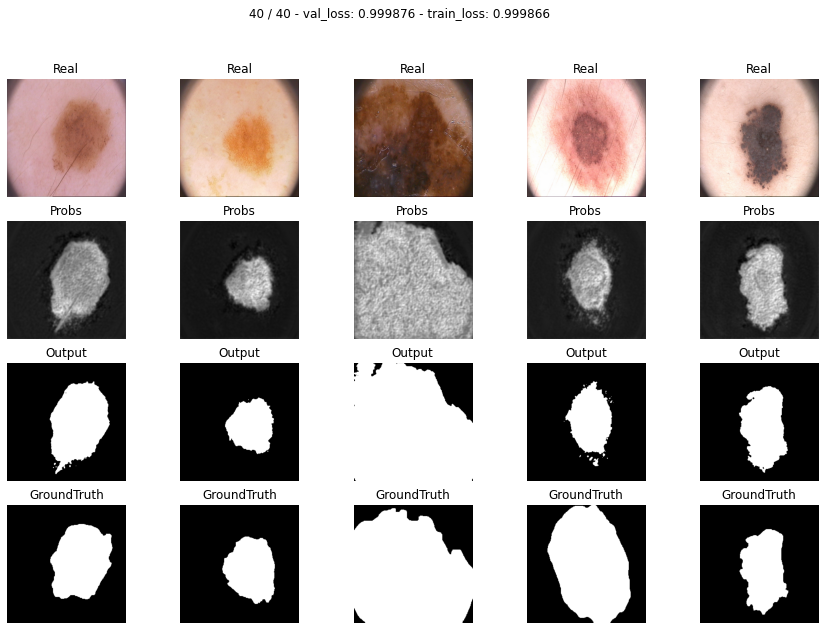

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_dice.parameters())
loss_tr_segnet_dice, loss_val_segnet_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_segnet_dice_csv = pd.DataFrame(columns=['train', 'val'])
loss_segnet_dice_csv['train'] = loss_tr_segnet_dice
loss_segnet_dice_csv['val'] = loss_val_segnet_dice
loss_segnet_dice_csv.to_csv('./gdrive/MyDrive/loss_segnet_dice_csv.csv', index=False)

In [ ]:
loss_segnet_dice_csv = pd.read_csv('./gdrive/MyDrive/loss_segnet_dice_csv.csv')
loss_tr_segnet_dice = loss_segnet_dice_csv['train']
loss_val_segnet_dice = loss_segnet_dice_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet_dice, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_segnet_dice,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Segnet, Dice Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
score_model(model_dice.cpu(), iou_pytorch, data_val)

0.6600000262260437

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    assert y_pred.shape[0] == y_real.shape[0], "predict & target batch size don't match"
    dim0 = y_pred.shape[0]

    prob = torch.sigmoid(y_pred).float().contiguous().view(dim0, -1)
    prob = torch.clamp(prob, eps, 1.0 - eps)

    y_real = y_real.float().contiguous().view(dim0, -1)
    
    pos_loss = - y_real * torch.pow(1 - prob, gamma) * torch.log(prob)  
    neg_loss = - torch.pow(prob, gamma) * (1 - y_real) * torch.log(1 - prob) # Ошибка в формуле
    
    loss = pos_loss + neg_loss

    return loss.mean()

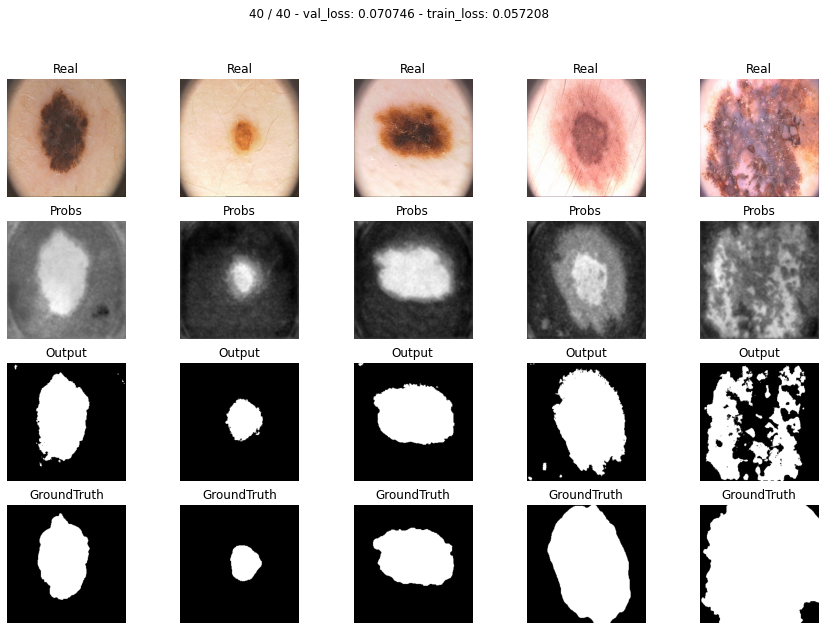

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_focal.parameters())
loss_tr_segnet_focal, loss_val_segnet_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_segnet_focal_csv = pd.DataFrame(columns=['train', 'val'])
loss_segnet_focal_csv['train'] = loss_tr_segnet_focal
loss_segnet_focal_csv['val'] = loss_val_segnet_focal
loss_segnet_focal_csv.to_csv('./gdrive/MyDrive/loss_segnet_focal_csv.csv', index=False)

In [ ]:
loss_segnet_focal_csv = pd.read_csv('./gdrive/MyDrive/loss_segnet_focal_csv.csv')
loss_tr_segnet_focal = loss_segnet_focal_csv['train']
loss_val_segnet_focal = loss_segnet_focal_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet_focal, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_segnet_focal,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Segnet, Focal Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
score_model(model_focal.cpu(), iou_pytorch, data_val)

0.6139999985694885

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

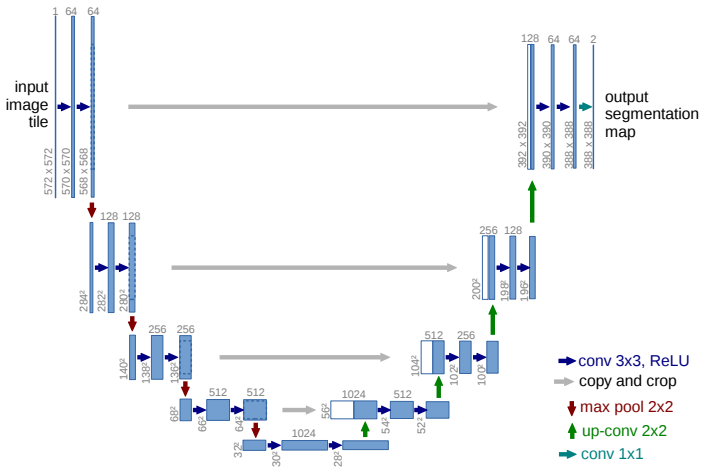

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential (
            nn.Conv2d(in_channels=3, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  

        self.enc_conv1 = nn.Sequential (
            nn.Conv2d(in_channels=64, padding=1, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, padding=1, out_channels=128, kernel_size=3),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv2 = nn.Sequential (
            nn.Conv2d(in_channels=128, padding=1, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=256, kernel_size=3),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv3 = nn.Sequential (
            nn.Conv2d(in_channels=256, padding=1, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=512, kernel_size=3),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential (
            nn.Conv2d(in_channels=512, padding=1, out_channels=1024, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, padding=1, out_channels=512, kernel_size=3),
            nn.ReLU()
        )
        
        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential (
            nn.Conv2d(in_channels=1024, padding=1, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=256, kernel_size=3),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential (
            nn.Conv2d(in_channels=512, padding=1, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=128, kernel_size=3),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential (
            nn.Conv2d(in_channels=256, padding=1, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU()
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential (
            nn.Conv2d(in_channels=128, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU()
        )

        self.output = nn.Conv2d(in_channels=64, padding=1, out_channels=1, kernel_size=3)
        

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))   #3: 256x256   ->  64: 128x128
        e1 = self.pool1(self.enc_conv1(e0))  #64: 128x128  ->  128: 64x64
        e2 = self.pool2(self.enc_conv2(e1))  #128: 64x64   ->  256: 32x32
        e3 = self.pool3(self.enc_conv3(e2))  #256: 32x32   ->  512: 32x32 -> 512: 16x16

        # bottleneck
        b = (self.bottleneck_conv(e3))             #512: 16x16   ->  1024: 16x16  ->  512: 16x16

        # decoder
        d0 = self.dec_conv0( torch.cat( (self.upsample0(b), self.enc_conv3(e2)), dim=1) )    #512: 16x16 -> 512: 32x32  ->  1024: 32x32 -> 512: 32x32
        d1 = self.dec_conv1( torch.cat( (self.upsample1(d0), self.enc_conv2(e1)), dim=1) )   #512: 32x32 -> 512: 64x64   ->  256: 64x64
        d2 = self.dec_conv2( torch.cat( (self.upsample2(d1), self.enc_conv1(e0)), dim=1) )   #256: 64x64 -> 256: 128x128   ->  128: 128x128
        d3 = self.dec_conv3( torch.cat( (self.upsample3(d2), self.enc_conv0(x)), dim=1) )    #128: 128x128 -> 128: 256x256 ->  64: 256x256
        d4 = self.output(d3)                                                                 #64: 256x256 -> 1:256x256
        return d4


In [ ]:
unet_model = UNet().to(device)

In [ ]:
unet_total_params = sum(p.numel() for p in unet_model.parameters())
unet_total_params

21978177

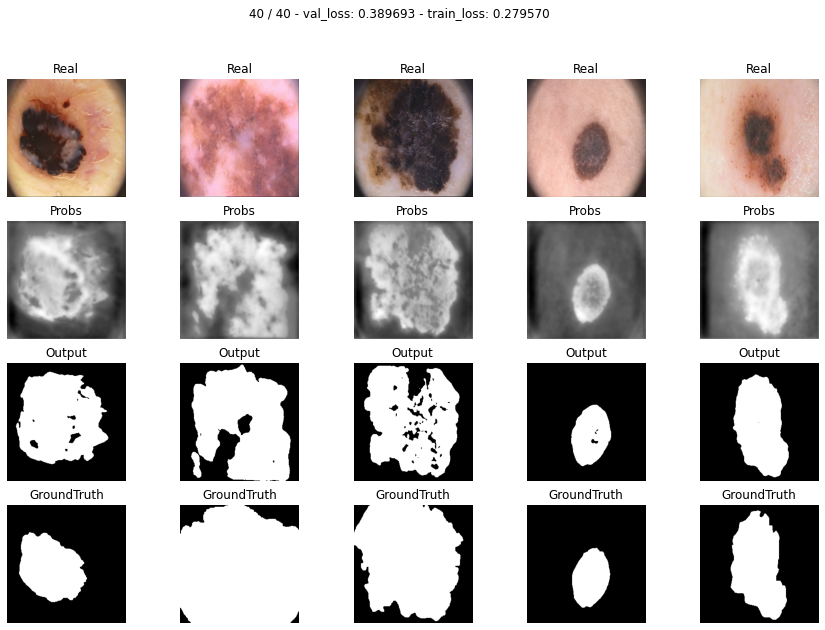

In [ ]:
max_epochs = 40
optimizer = optim.Adam(unet_model.parameters())
loss_tr_unet, loss_val_unet = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_unet_csv = pd.DataFrame(columns=['train', 'val'])
loss_unet_csv['train'] = loss_tr_unet
loss_unet_csv['val'] = loss_val_unet
loss_unet_csv.to_csv('./gdrive/MyDrive/loss_unet_csv.csv', index=False)

In [ ]:
loss_unet_csv = pd.read_csv('./gdrive/MyDrive/loss_unet_csv.csv')
loss_tr_unet = loss_unet_csv['train']
loss_val_unet = loss_unet_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_unet, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_unet,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="UNet, BCE Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
score_model(unet_model.cpu(), iou_pytorch, data_val)

0.6080000042915344

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential (
            nn.Conv2d(in_channels=3, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU()
        )

        self.pool0 = nn.Sequential (
            nn.Conv2d(in_channels=64, padding=0, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential (
            nn.Conv2d(in_channels=64, padding=1, out_channels=128, kernel_size=3),
            nn.ReLU()
        )

        self.pool1 = nn.Sequential (
            nn.Conv2d(in_channels=128, padding=0, out_channels=128, kernel_size=2, stride=2),
            nn.ReLU()
        )
            
       
        self.enc_conv2 = nn.Sequential (
            nn.Conv2d(in_channels=128, padding=1, out_channels=256, kernel_size=3),
            nn.ReLU()
        )
        self.pool2 = nn.Sequential (
            nn.Conv2d(in_channels=256, padding=0, out_channels=256, kernel_size=2, stride=2),
            nn.ReLU()
        )
            

        self.enc_conv3 = nn.Sequential (
            nn.Conv2d(in_channels=256, padding=1, out_channels=512, kernel_size=3),
            nn.ReLU()
        )
        self.pool3 = nn.Sequential (
            nn.Conv2d(in_channels=512, padding=0, out_channels=512, kernel_size=2, stride=2),
            nn.ReLU()
        )
            
            
        # bottleneck
        self.bottleneck_conv = nn.Sequential (
            nn.Conv2d(in_channels=512, padding=1, out_channels=1024, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, padding=1, out_channels=512, kernel_size=3),
            nn.ReLU()
        )
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential (
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, padding=1, out_channels=256, kernel_size=3),
            nn.ReLU()
        )

        self.dec_conv1 = nn.Sequential (
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, padding=1, out_channels=128, kernel_size=3),
            nn.ReLU()
        )

        self.dec_conv2 = nn.Sequential (
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU()
        )
        
        self.dec_conv3 = nn.Sequential (
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, padding=1, out_channels=64, kernel_size=3),
            nn.ReLU()
        )

        self.output = nn.Conv2d(in_channels=64, padding=1, out_channels=1, kernel_size=3)
        

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))   #3: 256x256   ->  64:256x256  ->  64: 128x128
        e1 = self.pool1(self.enc_conv1(e0))  #64: 128x128  ->  128: 128x128  ->  128: 64x64
        e2 = self.pool2(self.enc_conv2(e1))  #128: 64x64   ->  256: 64x64  ->  256: 32x32
        e3 = self.pool3(self.enc_conv3(e2))  #256: 32x32   ->  512: 32x32  ->  512: 16x16

        # bottleneck
        b = self.bottleneck_conv(e3)             #512: 16x16   ->  1024: 16x16  ->  512: 16x16  

        # decoder
        d0 = self.dec_conv0( torch.cat((b, e3), dim=1) )    #1024: 16x16  ->  256: 32x32
        d1 = self.dec_conv1( torch.cat((d0, e2), dim=1) )   #512: 32x32 -> 128: 64x64
        d2 = self.dec_conv2( torch.cat((d1, e1), dim=1) )   #256: 64x64 -> 64: 128x128
        d3 = self.dec_conv3( torch.cat((d2, e0), dim=1) )   #128: 128x128 -> 64: 256x256
        d4 = self.output(d3)                                #64: 256x256 -> 1:256x256
        return d4



# Unet2, BCE Loss

In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
unet2_total_params = sum(p.numel() for p in unet2_model.parameters())
unet2_total_params

16755777

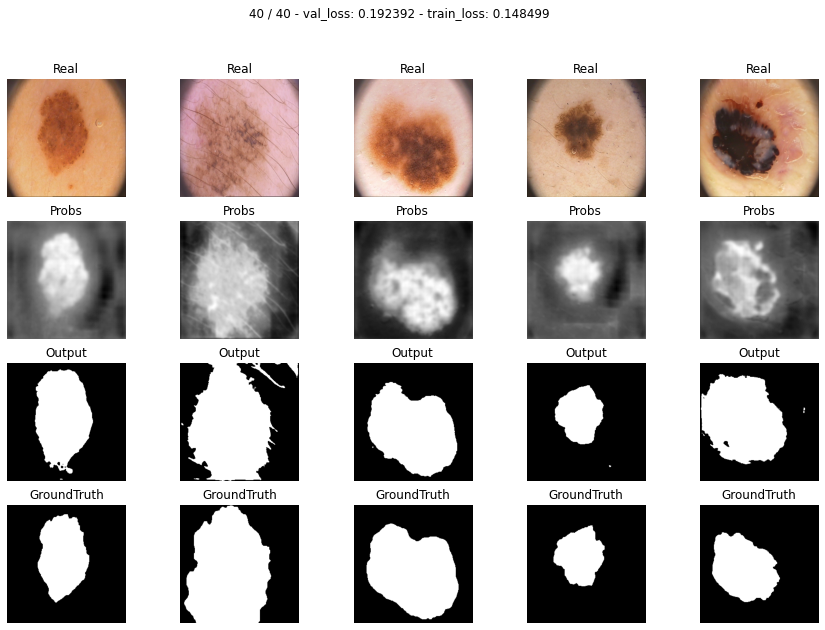

In [ ]:
max_epochs = 40
loss_tr_unet2, loss_val_unet2 = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_unet2_csv = pd.DataFrame(columns=['train', 'val'])
loss_unet2_csv['train'] = loss_tr_unet2
loss_unet2_csv['val'] = loss_val_unet2
loss_unet2_csv.to_csv('./gdrive/MyDrive/loss_unet2_csv.csv', index=False)

In [ ]:
loss_unet2_csv = pd.read_csv('./gdrive/MyDrive/loss_unet2_csv.csv')
loss_tr_unet2 = loss_unet2_csv['train']
loss_val_unet2 = loss_unet2_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_unet2, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_unet2,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="UNet2, BCE Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
score_model(unet2_model.cpu(), iou_pytorch, data_val)

0.7020000100135804

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_unet, name="Unet, BCE Loss")) 
fig.add_trace(go.Scatter(y=loss_val_unet2,name="Unet2, BCE Loss")) 
fig.add_trace(go.Scatter(y=loss_val_segnet, name="SegNet, BCE Loss")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="BCE Loss Function: comparison of architectures",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))

fig.show()

# Unet2, Dice Loss

In [ ]:
unet2_model_dice = UNet2().to(device)

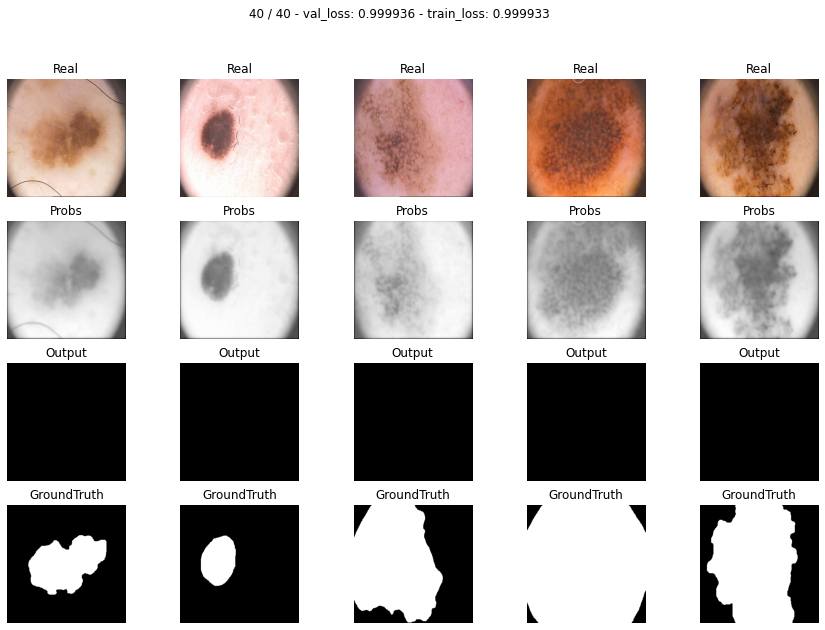

In [ ]:
max_epochs = 40
loss_tr_unet2_dice, loss_val_unet2_dice = train(unet2_model_dice, optim.Adam(unet2_model_dice.parameters()), dice_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_unet2_dice_csv = pd.DataFrame(columns=['train', 'val'])
loss_unet2_dice_csv['train'] = loss_tr_unet2_dice
loss_unet2_dice_csv['val'] = loss_val_unet2_dice
loss_unet2_dice_csv.to_csv('./gdrive/MyDrive/loss_unet2_dice_csv.csv', index=False)

In [ ]:
loss_unet2_dice_csv = pd.read_csv('./gdrive/MyDrive/loss_unet2_dice_csv.csv')
loss_tr_unet2_dice = loss_unet2_dice_csv['train']
loss_val_unet2_dice = loss_unet2_dice_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_unet2_dice, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_unet2_dice,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="UNet2, Dice Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

твой лосс скачет вверх и вниз, как агутин.

мой лосс стабилен, как владимир путин!

раунд!

In [ ]:
score_model(unet2_model_dice.cpu(), iou_pytorch, data_val)

0.11000000163912774

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet_dice, name="SegNet, Dice Loss")) 
fig.add_trace(go.Scatter(y=loss_val_unet2_dice,name="Unet2, Dice Loss")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Dice Loss Function: comparison of architectures",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

# Unet2, Focal Loss

In [ ]:
unet2_model_focal = UNet2().to(device)

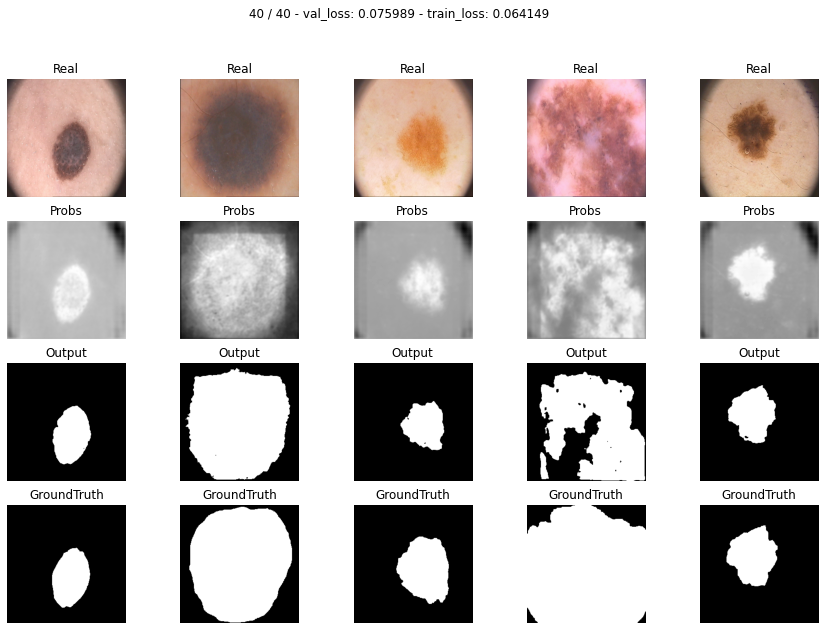

In [ ]:
max_epochs = 40
loss_tr_unet2_focal, loss_val_unet2_focal = train(unet2_model_focal, optim.Adam(unet2_model_focal.parameters()), focal_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_unet2_focal_csv = pd.DataFrame(columns=['train', 'val'])
loss_unet2_focal_csv['train'] = loss_tr_unet2_focal
loss_unet2_focal_csv['val'] = loss_val_unet2_focal
loss_unet2_focal_csv.to_csv('./gdrive/MyDrive/loss_unet2_focal_csv.csv', index=False)

In [ ]:
loss_unet2_focal_csv = pd.read_csv('./gdrive/MyDrive/loss_unet2_focal_csv.csv')
loss_tr_unet2_focal = loss_unet2_focal_csv['train']
loss_val_unet2_focal = loss_unet2_focal_csv['val']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_unet2_focal, name="val")) 
fig.add_trace(go.Scatter(y=loss_tr_unet2_focal,name="train")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="UNet2, Focal Loss Function",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
score_model(unet2_model_focal.cpu(), iou_pytorch, data_val)

0.5720000207424164

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet_focal, name="SegNet, Focal Loss")) 
fig.add_trace(go.Scatter(y=loss_val_unet2_focal,name="Unet2, Focal Loss")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Focal Loss Function: comparison of architectures",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# ОТЧЁТ

Что было сделано? Что получилось реализовать, что не получилось?
Какие результаты ожидалось получить?
Какие результаты были достигнуты?
Чем результаты различных подходов отличались друг от друга?

1. В ноутбуке реализована сеть с архитектурой **SegNet**. В моем варианте сети в декодере используются макс-пуллинги с ядром 2 и страйдом 2 с запоминанием индексов элементов; в энкодере - макс-анпуллинги по этим индексам. Было проведено три эксперимента для этой сети с разными функциями потерь: BCE, Dice и Focal Loss. IOU для этих моделей 0.678, 0.660, 0.614. соответственно. Лучший результат из этих трех вариантов показала сеть с BCE Loss.

2. Также реализованы варианты архитектур **Unet**. 
- В первом варианте в декодере используются макс-пуллинги с ядром 2 и страйдом 2, в энкодере - апсэмплы в 2 раза. 
- Во втором варианте в декодере - convolution-слои с ядром 2 и страйдом 2, в энкодере - transposed convolution с ядром 2 и страйдом 2. 
- В обоих вариантах используется конкатенация карт активаций энкодера с картами декодера одинакового размера.
- Проведено сравнение двух архитектур Unet и Unet2 с лоссом BCE: IOU для этих моделей 0.608 и 0.702 соответственно. Unet2 показывает лучшие результаты.

3. Было проведено три эксперимента для второго варианта сети **Unet2** с разными функциями потерь: BCE, Dice и Focal Loss. IOU для этих моделей 0.702, 0.11, 0.572 соответственно. Лучший результат показала сеть с BCE.

4. Проведено попарное сравнение архитектур **SegNet и Unet2** с разными лоссами. 
- IOU на отложенной выборке у SegNet и у Unet2 с BCE Loss: 0.678 и 0.702; результаты близки. 
- IOU на отложенной выборке у SegNet и у Unet2 с Focal Loss: 0.614 и 0.572; результаты близки. 
- IOU на отложенной выборке у SegNet и у Unet2 с Dice Loss: 0.660 и 0.11.Результат Unet2 значительно отличается от прочих, что может говорить об ошибках в архитектуре сети или в функции лосса. 
- Самое высокое значение IOU достигнуто в сети Unet2 c BCE Loss.

5. Модель Unet2 с Dice Loss практически **не обучилась**, что может говорить об ошибках в архитектуре модели или в функции лосса.

6. Количество параметров сетей (в порядке убывания): Segnet 24980929 (около 25 млн.), Unet 21978177 (около 22 млн), Unet2 16755777 (около 17 млн). Unet2 имеет в 1,5 раза меньше параметров, чем SegNet, и при этом показывает лучшее качество.


7. Можно было бы сделать выводы, что модель Unet2 с BCE Loss лучшая, но это не совсем так. Результаты получились не совсем точные, в зависимости от случайного разбиения выборок при каждом новом запуске точность моделей меняется в пределах 5-10%. Рекомендуется внести изменения в модель:
- добавить разумное количество аугментаций,
- увеличить количество эпох обучения.

  Делать мы этого конечно не будем.



In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_unet, name="Unet, BCE Loss")) 
fig.add_trace(go.Scatter(y=loss_val_unet2,name="Unet2, BCE Loss")) 
fig.add_trace(go.Scatter(y=loss_val_segnet, name="SegNet, BCE Loss")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="BCE Loss Function: comparison of architectures",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet_dice, name="SegNet, Dice Loss")) 
fig.add_trace(go.Scatter(y=loss_val_unet2_dice,name="Unet2, Dice Loss")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Dice Loss Function: comparison of architectures",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_val_segnet_focal, name="SegNet, Focal Loss")) 
fig.add_trace(go.Scatter(y=loss_val_unet2_focal,name="Unet2, Focal Loss")) 
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Focal Loss Function: comparison of architectures",
                  xaxis_title="epochs",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

## Сравнительная таблица ##

In [ ]:
import pandas as pd

comparison = pd.DataFrame({'Model': ['SegNet', 'Unet2', 'Unet'], 
                   'BCE Loss': ['0.678', '0.702', '0.608'],
                   'Dice Loss': ['0.660', '0.110', ''],
                   'Focal Loss': ['0.614', '0.572', ''],
                   'Num. of ps': [segnet_total_params, unet2_total_params, unet_total_params]
                   })

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

comparison

,Model,BCE Loss,Dice Loss,Focal Loss,Num. of ps
0,SegNet,0.678,0.660,0.614,24980929
1,Unet2,0.702,0.110,0.572,16755777
2,Unet,0.608,,,21978177
